In [1]:
import folium
import mglearn
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

import numbers
import math
from math import radians, sin,cos,atan2,sqrt

import scipy
import scipy.cluster.hierarchy as sch
import scipy.cluster.hierarchy as shc

from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from math import radians, sin,cos,atan2,sqrt

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
data_ci=pd.read_csv('data_ci.csv')

# 위도 경도를 통한 거리 계산 코드

In [3]:
def get_euclidean_distance(x1, y1, x2, y2, round_decimal_digits=5):        
    """
    유클리안 Formula 이용하여 (x1,y1)과 (x2,y2) 점의 거리를 반환
    """
    if x1 is None or y1 is None or x2 is None or y2 is None:
        return None
    assert isinstance(x1, numbers.Number) and -180 <= x1 and x1 <= 180
    assert isinstance(y1, numbers.Number) and  -90 <= y1 and y1 <=  90
    assert isinstance(x2, numbers.Number) and -180 <= x2 and x2 <= 180
    assert isinstance(y2, numbers.Number) and  -90 <= y2 and y2 <=  90

    dLon = abs(x2-x1) # 경도 차이
    if dLon >= 180:   # 반대편으로 갈 수 있는 경우
        dLon -= 360   # 반대편 각을 구한다
    dLat = y2-y1      # 위도 차이
    return round(math.sqrt(pow(dLon,2)+pow(dLat,2)),round_decimal_digits)


# 타일 만들기

In [4]:
data_total=pd.read_csv('data_total.csv')
data_total.drop('Unnamed: 0', axis =1 ,inplace=True)
data_total['clus']=pd.cut(data_total.동별_친환경자동차수 ,10,labels=[1,2,3,4,5,6,7,8,9,10])
df = data_total.copy()
x=df[['edu_percent', '동별_친환경자동차수', 
       '합계_사업체수', '㎡당 매매평균가',  '가구수별_승용차수', '동별_수소차_대수','택시']]
x = x.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
x_scaled = StandardScaler().fit_transform(x_scaled)
df1 = pd.DataFrame(x_scaled)
df1['sum1']=df1.sum(axis = 1, skipna = True) 
df1.columns=['edu_percent', '동별_친환경자동차수', '합계_사업체수',
       '㎡당 매매평균가', '가구수별_승용차수', '동별_수소차_대수', '택시', 'sum1']
df=df[['자치구', '동','clus']]
df_norm=df.merge(df1,left_index=True,right_index=True)

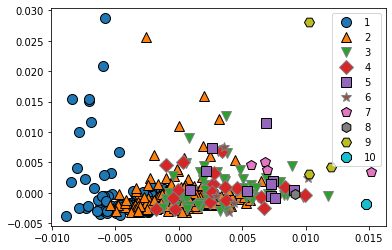

In [5]:
X=df_norm.iloc[:,3:11]
y=df_norm.iloc[:,2]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=9)
x = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
x = x.reshape((x.shape[0], -1))
x = np.divide(x, 255.)
# 10 clusters
n_clusters = len(np.unique(y))
# Runs in parallel 4 CPUs
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
# Train K-Means.
y_pred_kmeans = kmeans.fit_predict(x)
# Evaluate the K-Means clustering accuracy.
metrics.accuracy_score(y, y_pred_kmeans)


# 군집모델 형성
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
y_pred = KMeans(n_clusters=3, random_state=0).fit_predict(x)

mglearn.discrete_scatter(x[:, 0], x[:, 2], y)
plt.legend([1,2,3,4,5,6,7,8,9,10], loc='best')

# 방법론 합치기

In [6]:
sum_norm = df_norm[['자치구', '동', 'sum1']]
data_total= data_total.merge(sum_norm, how ='inner', on=['자치구','동'])
data_total['sum_clus']=pd.qcut(data_total['sum1'] ,10,labels=[1,2,3,4,5,6,7,8,9,10])
data_ci=data_ci[['자치구', '동', 'cluster',
       '총_점수_interval_10', '수소충전소']]
data_total= data_total.merge(data_ci, how ='inner', on=['자치구','동'])
data_total.clus=data_total.clus.astype('int')
data_total.sum_clus=data_total.sum_clus.astype('int')

# Folium에 수소충전소(완공예정) 체크

In [7]:
geo_path = "geoData_Seoul.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

In [8]:
# 타일 넣기
seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="cartodbpositron")
folium.Choropleth(geo_data=geo_str, 
                     data = data_total ,
                     columns=['동', 'sum1'],
                     fill_color='RdPu',  # GnBu
                     key_on='properties.name',
                     highlight=True,
                     fill_opacity=0.5,
                     line_opacity=1,
                     legend_name="sum1").add_to(seoul_map)

In [9]:
# 양재 수소충전소를 찍어보자.
folium.Marker(
  location=[37.4686275,127.0319203],
  popup='양재 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 상암 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5687204,126.8761933],
  popup='상암 수소 충전소 위치.',
  icon=folium.Icon(color='red',icon='star')
).add_to(seoul_map)

# 국회 수소 충전소를 찍어보자.
folium.Marker(
  location=[37.5311111,126.9132037],
  popup='2019년 완공 예정 국회 수소 충전소 위치.',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 강동구 상일충전소를 찍어보자.
folium.Marker(
  location=[37.5392486,127.128611],
  popup='2019년 완공 예정 강동구 상일충전소 위치',
  icon=folium.Icon(color='blue',icon='star')
).add_to(seoul_map)

# 강서공영차고지 수소생산기지 찍어보자.
folium.Marker(
  location=[37.5775641,126.7963879],
  popup=' 2020년 완공 예정 강서공영차고지 수소생산기지 버스용',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

# 탄천물재생센터 수소춘전소 찍어보자.
folium.Marker(
  location=[37.4915688,127.0671297],
  popup=' 2020년 완공 예정이지만 미정 탄천물재생센터 수소춘전소',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

# 현대자동차 계동사옥 수소춘전소 찍어보자.
folium.Marker(
  location=[37.566758,126.9584211],
  popup=' 아직 미정 현대자동차 계동사옥 수소춘전소',
  icon=folium.Icon(color='green',icon='star')
).add_to(seoul_map)

In [10]:
seoul_map.save('test.html')

# 주차장

In [12]:
parking = pd.read_csv('juchajang_final.csv',encoding= 'cp949')

In [13]:
parking

,Unnamed: 0,주차장관리번호,주차장명,주차장구분,주차장유형,주차구획수,급지구분,부제시행구분,운영요일,평일운영시작시각,...,관리기관명,전화번호,위도,경도_x,데이터기준일자,제공기관코드,제공기관명,Unnamed: 33,도로명주소,행정구역
0,0,115-2-000001,화곡본-2,공영,노외,100,5,미시행,평일,09:00,...,서울특별시 강서구청,02-2607-1570,37.544121,126.848553,2019-03-28,3150000,서울특별시 강서구,-1.0,서울특별시 강서구 초록마을로5길 46,화곡본동
1,1,115-2-000002,화곡2-1,공영,노외,60,5,미시행,평일,09:00,...,서울특별시 강서구청,02-2607-1419,37.535981,126.850238,2019-03-28,3150000,서울특별시 강서구,-1.0,서울특별시 강서구 강서로18바길 16-11,화곡제8동
2,2,115-2-000003,화곡3-1,공영,노외,99,5,미시행,평일,09:00,...,서울특별시 강서구청,02-2603-1573,37.541702,126.832546,2019-03-28,3150000,서울특별시 강서구,-1.0,서울특별시 양천구 월정로50길 22,신월5동
3,3,115-2-000004,화곡4-1,공영,노외,138,5,미시행,평일,07:00,...,서울특별시 강서구청,02-2645-1574,37.541702,126.825979,2019-03-28,3150000,서울특별시 강서구,-1.0,서울특별시 양천구 화곡로3길 27-8,신월5동
4,4,115-2-000006,화곡5-2,공영,노외,25,5,미시행,평일,09:00,...,서울특별시 강서구청,02-2604-8688,37.544177,126.838548,2019-03-28,3150000,서울특별시 강서구,-1.0,서울특별시 강서구 강서로 200,우장산동
5,5,115-2-000007,화곡5-3,공영,노외,17,5,미시행,평일,09:00,...,서울특별시 강서구청,02-2604-8688,37.543329,126.833544,2019-03-28,3150000,서울특별시 강서구,-1.0,서울특별시 강서구 강서로37길 71,화곡제3동
6,6,115-2-000008,화곡7-1,공영,노외,86,5,미시행,평일,09:00,...,서울특별시 강서구청,02-2699-8671,37.544601,126.834701,2019-03-28,3150000,서울특별시 강서구,-1.0,서울특별시 강서구 강서로45다길 74,화곡제3동
7,7,115-2-000009,등촌2-1,공영,노외,91,5,미시행,평일,09:00,...,서울특별시 강서구청,02-2645-1578,37.549757,126.859126,2019-03-28,3150000,서울특별시 강서구,-1.0,서울특별시 강서구 등촌로51길 80,등촌제2동
8,8,115-2-000010,화곡6-1,공영,노외,300,4,미시행,평일+토요일,07:00,...,서울특별시 강서구청,02-2607-9113,37.552979,126.846266,2019-03-28,3150000,서울특별시 강서구,-1.0,서울특별시 강서구 우장산로 92,화곡제6동
9,9,115-2-000014,화곡본-1,공영,노외,99,5,미시행,평일,09:00,...,서울특별시 강서구청,02-2065-8751,37.539703,126.847571,2019-03-28,3150000,서울특별시 강서구,-1.0,서울특별시 강서구 까치산로4길 75-20,화곡본동


In [14]:
kk= pd.DataFrame(set(parking.행정구역) - set(data_total.동))

In [15]:
kk['동'] = kk[0].str.replace("제","")

In [16]:
kk.drop(0,inplace=True)

In [17]:
for i in range(len(parking)):
    for p in range(len(kk)):
        if parking['행정구역'].iloc[i] == kk[0].iloc[p]:
            parking['행정구역'].iloc[i] = kk['동'].iloc[p]
            break

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
parking.행정구역.replace('여의도동','여의동', inplace=True)
parking.행정구역.replace('종로1·2·3·4가동','종로1.2.3.4가동', inplace=True)
parking.행정구역.replace('상계3·4동','상계3.4동', inplace=True)
parking.행정구역.replace('금호2·3가동','금호2.3가동', inplace=True)

In [19]:
parking.columns=['Unnamed: 0', '주차장관리번호', '주차장명', '주차장구분', '주차장유형', '주차구획수', '주차급지구분',
       '주차부제시행구분', '주차운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각',
       '공휴일운영시작시각', '공휴일운영종료시각', '주차요금정보', '주차기본시간', '주차기본요금', '추가단위시간',
       '추가단위요금', '1일주차권요금적용시간', '1일주차권요금', '월정기권요금', '결제방법', '특기사항', '관리기관명',
       '전화번호', '주차위도', '주차경도', '데이터기준일자', '제공기관코드', '제공기관명', 'Unnamed: 33',
       '도로명주소', '동']

In [20]:
parking=parking[['주차장명','주차장구분', '주차장유형',
                '주차구획수',
       '주차급지구분', '주차부제시행구분', '주차운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각',
       '토요일운영종료시각', '주차요금정보', '주차기본시간', '주차기본요금',
               '주차경도', '주차위도', '동' ]]

In [21]:
parking.주차장유형.unique()

array(['노외', '노상', '부설'], dtype=object)

In [22]:
parking[(parking.주차장구분=='공영')&(parking['주차구획수']>10)].reset_index(drop=True)

,주차장명,주차장구분,주차장유형,주차구획수,주차급지구분,주차부제시행구분,주차운영요일,평일운영시작시각,평일운영종료시각,토요일운영시작시각,토요일운영종료시각,주차요금정보,주차기본시간,주차기본요금,주차경도,주차위도,동
0,화곡본-2,공영,노외,100,5,미시행,평일,09:00,19:00,00:00,00:00,유료,5,50,126.848553,37.544121,화곡본동
1,화곡2-1,공영,노외,60,5,미시행,평일,09:00,19:00,00:00,00:00,유료,5,50,126.850238,37.535981,화곡8동
2,화곡3-1,공영,노외,99,5,미시행,평일,09:00,19:00,00:00,00:00,유료,5,50,126.832546,37.541702,신월5동
3,화곡4-1,공영,노외,138,5,미시행,평일,07:00,23:00,09:00,15:00,유료,5,50,126.825979,37.541702,신월5동
4,화곡5-2,공영,노외,25,5,미시행,평일,09:00,18:00,00:00,00:00,유료,5,50,126.838548,37.544177,우장산동
5,화곡5-3,공영,노외,17,5,미시행,평일,09:00,18:00,00:00,00:00,유료,5,50,126.833544,37.543329,화곡3동
6,화곡7-1,공영,노외,86,5,미시행,평일,09:00,19:00,00:00,00:00,유료,5,50,126.834701,37.544601,화곡3동
7,등촌2-1,공영,노외,91,5,미시행,평일,09:00,19:00,00:00,00:00,유료,5,50,126.859126,37.549757,등촌2동
8,화곡6-1,공영,노외,300,4,미시행,평일+토요일,07:00,23:00,07:00,23:00,유료,5,100,126.846266,37.552979,화곡6동
9,화곡본-1,공영,노외,99,5,미시행,평일,09:00,19:00,00:00,00:00,유료,5,50,126.847571,37.539703,화곡본동


In [23]:
parking = parking[~(parking.주차장유형=='노상')].reset_index()

In [24]:
parking.drop_duplicates(subset ="주차장명", 
                     keep = 'first', inplace=True)

In [25]:
parking=parking[['주차장명', '주차장구분', '주차장유형', '주차구획수', '주차급지구분',
       '주차부제시행구분', '주차운영요일', '평일운영시작시각', '평일운영종료시각', '토요일운영시작시각', '토요일운영종료시각',
       '주차요금정보', '주차기본시간', '주차기본요금',  '주차경도','주차위도', '동']]

In [26]:
parking.reset_index(drop=True, inplace=True)

# LPG

In [11]:
lpg = pd.read_csv('lpg_location.csv',engine='python' ,encoding='cp949')

In [28]:
k =pd.DataFrame(set(lpg.행정동)-set(data_total.동))

In [35]:
for i in range(len(lpg)):
    for p in range(len(k)):
        if lpg['행정동'].iloc[i] == kk[0].iloc[p]:
            lpg['행정동'].iloc[i] = kk['동'].iloc[p]
            break

In [36]:
lpg.행정동.replace('54','공릉1동', inplace=True)
lpg.행정동.replace('69','중곡1동', inplace=True)
lpg.행정동.replace('중계2·3동','중계2.3동', inplace=True)

In [37]:
lpg.columns = ['Unnamed: 0', '업체명', '도로주소', '동주소', '경도', '위도', '동']
lpg=lpg[['업체명','동주소', '경도', '위도', '동']]
lpg[lpg.duplicated('동')]

,업체명,동주소,경도,위도,동
7,남서울가스(주),서울특별시 강남구 남부순환로 3154,37.497780,127.073376,일원2동
10,(주)수서에너지,서울특별시 강남구 밤고개로 127,37.482796,127.102826,세곡동
19,(주)삼표에너지 수색충전소,서울특별시 은평구 수색로 181,37.577704,126.899168,증산동
28,강서가스충전소,서울특별시 강서구 벌말로 266,37.554977,126.766738,공항동
33,(주)에너지플러스 오곡동충전소,서울특별시 강서구 벌말로 271,37.555591,126.766019,공항동
46,복지개화충전소,서울특별시 강서구 개화동로 416,37.574714,126.799557,방화2동
48,대영가스 충전소,서울특별시 강서구 양천로 242,37.565116,126.806539,가양제1동
72,한양에너지(주),서울특별시 광진구 동일로 381,37.564958,127.074351,중곡1동
74,태능가스(주),서울특별시 노원구 화랑로 405,37.616956,127.070336,공릉1동
76,복지노원충전소,서울특별시 노원구 동일로 1778,37.686866,127.053645,상계1동


In [38]:
data_total_gas = data_total.merge(lpg, on=['동'], how='left')

### LPG 주유소 위치 찍기

In [42]:
for i in range(len(lpg.loc[:,['경도','위도']])):
    folium.Marker(
        location=lpg.loc[i,['경도','위도']],
        popup=lpg.loc[i,['동']],
        icon=folium.Icon(color='lightgray',icon='home')
    ).add_to(seoul_map)

In [184]:
select_dong = data_total[['자치구','동','sum1']]

In [185]:
select_dong['동'] = select_dong["동"].str.replace("제","")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [174]:
# select_dong=select_dong.set_index(['자치구'])

In [186]:
parking["동"]=parking["동"].str.replace("제","")

In [187]:
lpg["동"]=lpg["동"].str.replace("제","")

In [188]:
data_total_gas_pk = lpg.merge(parking, on=['동'], how='left')

In [189]:
data_total_gas_pk=pd.merge(data_total_gas_pk, select_dong, how="left")

In [206]:
data_gas=data_total_gas_pk[['자치구', '동', '업체명', '동주소', '경도', '위도','sum1']]

In [207]:
data_gas.drop_duplicates("위도", inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [208]:
data_gas.reset_index(drop=True, inplace=True)

In [209]:
data_gas=data_gas[~(data_gas['자치구']=='강서구')]
data_gas=data_gas[~(data_gas['자치구']=='서초구')]

In [210]:
data_gas.reset_index(drop=True, inplace=True)

In [211]:
dist=pd.read_csv("lpg_total_distance.csv",encoding="cp949")

In [212]:
dist.drop(columns="Unnamed: 0", inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


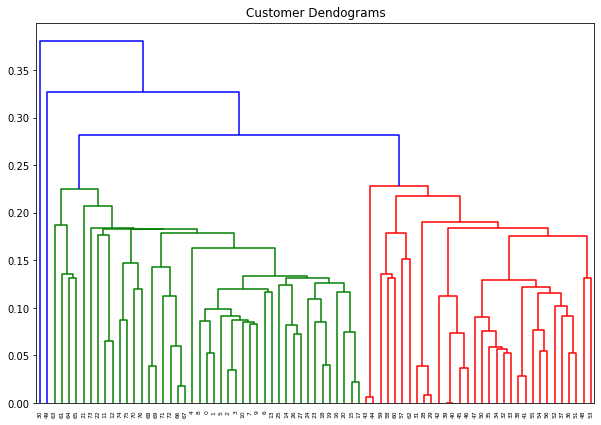

In [213]:
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(dist, method='single'))

In [268]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='single')
cluster.fit_predict(dist)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:463: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [269]:
data_gas['sing_clus']=pd.DataFrame(cluster.fit_predict(dist))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\hierarchical.py:463: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


In [271]:
data_gas

,자치구,동,업체명,동주소,경도,위도,sum1,sing_clus
0,강남구,세곡동,강남복지충전소,서울특별시 강남구 밤고개로 200,37.476329,127.103276,18.364857,1
1,강남구,논현2동,(주)상현상사,서울특별시 강남구 학동로 204,37.513631,127.029157,10.790736,1
2,강동구,암사2동,암사충전소,서울특별시 강동구 올림픽로 791,37.551779,127.125545,-2.686122,1
3,강남구,도곡1동,진양가스,서울특별시 강남구 강남대로58길 61,37.490583,127.034634,9.671090,1
4,강남구,일원2동,대치에너지주식회사,서울특별시 강남구 남부순환로 3179,37.499300,127.075901,6.934460,1
5,강남구,일원2동,남서울가스(주),서울특별시 강남구 남부순환로 3154,37.497780,127.073376,6.934460,1
6,동작구,사당1동,수도석유(주)방배충전소,서울특별시 서초구 동작대로 26,37.486896,126.973018,0.380435,1
7,강동구,상일동,복지상일충전소,서울특별시 강동구 천호대로 1452,37.545049,127.167585,-3.410521,1
8,강남구,세곡동,(주)수서에너지,서울특별시 강남구 밤고개로 127,37.482796,127.102826,18.364857,1
9,강동구,성내2동,(주)경기에너지,서울특별시 강동구 천호대로 1056,37.536485,127.126803,-0.661485,1


In [270]:
data_gas.groupby(['sing_clus','자치구','동']).agg({'sum1':'mean'})

sum1
sing_clus 자치구  동                
0         강북구  번1동     -5.546941
               번3동     -6.144617
               수유1동    -5.582651
          관악구  낙성대동    -2.169481
          광진구  자양1동    -2.031268
               중곡1동    -4.234507
          구로구  구로2동     3.805830
          노원구  공릉1동    -1.352584
               공릉2동    -1.597204
               중계2.3동  -2.218264
          도봉구  도봉1동    -4.901648
               방학1동    -3.652481
               쌍문2동    -5.416291
               창2동     -3.522902
          동대문구 답십리2동   -1.971604
               장안1동     0.354721
               청량리동    -3.252931
               휘경1동    -5.086607
          성동구  성수1가2동  -0.572389
               성수2가3동  -0.244425
          성북구  길음2동    -5.833073
               장위3동    -5.874473
          양천구  신월1동    -0.951737
               신월5동    -2.341178
               신월7동    -0.904973
               신정4동     3.185930
          영등포구 양평1동     0.949375
          중랑구  망우본동    -2.803940
               면목5동    -6.765307
               신내1동    -2.585365
               중화2동    -3.682618
1         강남구  논현2동    10.790736
               도곡1동     9.671090
               세곡동     18.364857
               일원2동     6.934460
          강동구  둔촌2동     1.762095
               상일동     -3.410521
               성내2동    -0.661485
               암사2동    -2.686122
          관악구  서림동     -1.152233
          구로구  구로3동     2.279064
               수궁동     -1.598244
               오류2동     1.663784
          금천구  독산2동    -2.575092
          노원구  공릉1동    -1.352584
               상계1동    -0.774839
          동작구  대방동      3.624785
               사당1동     0.380435
          서대문구 북가좌1동   -2.653883
          송파구  석촌동      3.914528
               오금동      5.464928
               잠실본동     5.370023
          양천구  신정3동     4.723433
               신정7동     1.148857
          영등포구 문래동      4.918385
               양평2동     1.442763
          은평구  증산동     -4.432447
               진관동      2.014596
2         노원구  상계1동    -0.774839
3         구로구  개봉1동     0.047880

In [ ]:
for i in range(len(top_5_drop.loc[:,['경도','위도']])):
    folium.Marker(
        location=top_5_drop.loc[i,['경도','위도']],
        popup=top_5_drop.loc[i,['동']],
        icon=folium.Icon(color='lightgray',icon='home')
    ).add_to(seoul_map)

In [272]:
seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="cartodbpositron")
seoul_map.choropleth(geo_data=geo_str, 
                     data = data_total ,
                     columns=['동', 'sum1'],
                     fill_color='RdPu',  # GnBu
                     key_on='properties.name',
                     highlight=True,
                     fill_opacity=0.5,
                     line_opacity=1,
                     legend_name="sum1")
seoul_map.save("size.html")

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [273]:
for i in range(len(data_gas.loc[:,['경도','위도']])):
    folium.Marker(
        location=data_gas.loc[i,['경도','위도']],
        popup=data_gas.loc[i,['동']],
        icon=folium.Icon(color='lightgray',icon='home')
    ).add_to(seoul_map)

In [274]:
seoul_map.save("size.html")

In [ ]:
def top_dong(hybrid=2):
    data_gas=data_total_lpg_1[['자치구', '동','sum_2', 'interval_1', '수소충전소', '업체명', '동주소', '경도', '위도' ]]
    data_gas.drop_duplicates(subset ="업체명", keep = 'first', inplace=True)
    data_gas.dropna(inplace=True)

    # 수소충전소가 이미 있는 지역은 제외
    indexexist = data_gas[(data_gas['자치구'].isin(data_gas[(data_gas['수소충전소']==1)].자치구))].index
    data_gas.drop(indexexist, inplace=True)

    # 중첩분석 8등급 이상인 주유소만 가져오기 
    data_gas=data_gas[(data_gas['interval_1']>7)]
    data_gas.reset_index(drop=True, inplace=True)

In [280]:
data_gas

,자치구,동,업체명,동주소,경도,위도,sum1,sing_clus
0,강남구,세곡동,강남복지충전소,서울특별시 강남구 밤고개로 200,37.476329,127.103276,18.364857,1
1,강남구,논현2동,(주)상현상사,서울특별시 강남구 학동로 204,37.513631,127.029157,10.790736,1
2,강동구,암사2동,암사충전소,서울특별시 강동구 올림픽로 791,37.551779,127.125545,-2.686122,1
3,강남구,도곡1동,진양가스,서울특별시 강남구 강남대로58길 61,37.490583,127.034634,9.671090,1
4,강남구,일원2동,대치에너지주식회사,서울특별시 강남구 남부순환로 3179,37.499300,127.075901,6.934460,1
5,강남구,일원2동,남서울가스(주),서울특별시 강남구 남부순환로 3154,37.497780,127.073376,6.934460,1
6,동작구,사당1동,수도석유(주)방배충전소,서울특별시 서초구 동작대로 26,37.486896,126.973018,0.380435,1
7,강동구,상일동,복지상일충전소,서울특별시 강동구 천호대로 1452,37.545049,127.167585,-3.410521,1
8,강남구,세곡동,(주)수서에너지,서울특별시 강남구 밤고개로 127,37.482796,127.102826,18.364857,1
9,강동구,성내2동,(주)경기에너지,서울특별시 강동구 천호대로 1056,37.536485,127.126803,-0.661485,1


In [287]:
sing_top_dong=data_gas.groupby(['sing_clus','자치구','동','업체명']).agg({'sum1':'mean'})

In [291]:
sing_index= sing_top_dong.sort_values(by='sum1', ascending=False).groupby('sing_clus').head(1)

In [296]:
# top 업체명 list 뽑기
top_lpg = sing_index.index.get_level_values('업체명').tolist()
top_data = data_gas[(data_gas.업체명.isin(top_lpg))]


# 추천 lpg 주유소 보이기
top_data.reset_index(drop=True, inplace=True)
for i in range(len(top_data)):
    folium.Marker(
        location=top_data.loc[i,['경도','위도']],
        popup=top_data.loc[i,['동']],
        icon=folium.Icon(color='lightgray',icon='home')
    ).add_to(seoul_map)
seoul_map
seoul_map.save("seoul_map.html")

In [295]:
seoul_map = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, tiles="cartodbpositron")
seoul_map.choropleth(geo_data=geo_str, 
                     data = data_total ,
                     columns=['동', 'sum1'],
                     fill_color='RdPu',  # GnBu
                     key_on='properties.name',
                     highlight=True,
                     fill_opacity=0.5,
                     line_opacity=1,
                     legend_name="sum1")
seoul_map.save("seoul_map.html")

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
